In [1]:
import uuid

In [2]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [3]:
# (Optional) Enable tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "healthcare-transcripts"

if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LANGCHAIN_API_KEY: ")

In [4]:
import pandas as pd

data = pd.read_parquet("hf://datasets/urvog/llama2_transcripts_healthcare_callcenter/data/train-00000-of-00001-643ef6d7d804c522.parquet")

In [5]:
import logging
import operator
from typing import Annotated, List, Optional, TypedDict, Sequence
from langchain_core.messages import BaseMessage

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("health-chats-graph")

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    prompt: Annotated[Sequence[BaseMessage], operator.add]

In [29]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model='claude-3-haiku-20240307')

######## PII ########
# Patient Name
# Phone number, email, 
# Patient ID
# Birthdate
# Medications or prescription
# Policy number and insurance details
#####################

def remove_patient_name_number_email(state: State):
    user_input = state['messages'][-1]

    prompt = f"""Your task is to redact the patient's name, phone number and email from the following input. 
    You can refer to the patient as [PATIENT], phone number as [PHONE NUMBER] and email as [EMAIL]. It's really important that you redact only name, phone number and email information.
    INPUT: {user_input}
    """
    response = llm.invoke(prompt)
    return {"messages": [response.content], "prompt": [prompt]}

def remove_patient_id(state: State):
    user_input = state['messages'][-1]

    prompt = f"""Your task is to redact the patient's ID from the following input. You can refer to the patient actual id as [PATIENT ID]. 
    It's really important that you redact only the ID information.
    INPUT: {user_input}
    """
    response = llm.invoke(prompt)
    return {"messages": [response.content], "prompt": [prompt]}

def remove_patient_birthdate(state: State):
    user_input = state['messages'][-1]

    prompt = f"""Your task is to redact the patient's birthdate from the following input. You can refer to the patient's actual birthdate as [BIRTHDATE]. 
    It's really important that you redact patient's birth day information.
    INPUT: {user_input}
    """
    response = llm.invoke(prompt)
    return {"messages": [response.content], "prompt": [prompt]}

def remove_patient_medications(state: State):
    user_input = state['messages'][-1]

    prompt = f"""Your task is to redact the patient's medication from the following input. You can refer to patient's actual medication as [MEDICATIONS] and actual dosage as [DOSAGE].
    It's really important that you redact only the medications.
    INPUT: {user_input}
    """
    response = llm.invoke(prompt)
    return {"messages": [response.content], "prompt": [prompt]}

def remove_patient_insurance(state: State):
    user_input = state['messages'][-1]

    prompt = f"""Your task is to redact the patient's policy number from the following input. You can refer to the actual policy number as [POLICY NUMBER].
    It's really important that you redact this information.
    INPUT: {user_input}
    """
    response = llm.invoke(prompt)
    return {"messages": [response.content], "prompt": [prompt]}
 
def get_symptoms_and_recommendations(state: State):
    agent_output = state['messages'][-1]

    prompt = """
    You have a task to return a dictionary with three keys - main_reason, symptoms and recommendations. If there's nothing for these categories, simply say "N/A"

    1. For main_reason, list the main reason for why the patient called.
    1. For symptoms, simply write what the symptoms patient reported.
    2. For recommendations, list two recommendations that the agent recommended. 

    Here's the format I'm expecting:
    {
        "main_reason: [],
        "symptoms": [],
        "recommendations": []
    }
    """ + agent_output
    
    response = llm.invoke(prompt)
    return {"messages": [response.content], "prompt": [prompt]}

def create_a_general_summary(state: State):
    agent_output = state['messages'][-1]
    
    prompt = """
    Given the input, create a general summary with less than 150 words.""" + agent_output

    response = llm.invoke(prompt)
    return {"messages": [response.content],  "prompt": [prompt]}

def should_continue(state: State):
    # Check if we should continue to the next step or loop over the current
    counter = state["counter"][0]
    if counter == 3:
        return "extract"
    return "continue"

def write_to_file(state: State):    
    previous_responses = pd.read_excel("responses.xlsx", sheet_name="Sheet1")

    all_prompts = {f"prompt-{idx+1}": prompt for idx, prompt in enumerate(state['prompt'])}
    all_responses = {f"response-{idx+1}": response for idx, response in enumerate(state['messages'][1:])}
    document = {"document": state['messages'][0]}
    batch_id = {"batch_id": uuid.uuid1().hex}    
    
    updated_responses = pd.concat([
        previous_responses,
        pd.DataFrame([{**document, **batch_id, **all_prompts, **all_responses}])
    ])
    updated_responses.to_excel("responses.xlsx", index=False)
    

In [30]:
# remove_patient_name_number_email
# remove_patient_id
# remove_patient_birthdate
# remove_patient_medications
# remove_patient_insurance

In [31]:
from langgraph.graph import StateGraph, Graph, START, END

workflow = StateGraph(State)

workflow.add_node("pii_name_number_email", remove_patient_name_number_email)
workflow.add_node("pii_id", remove_patient_id)
workflow.add_node("pii_birthdate", remove_patient_birthdate)
workflow.add_node("pii_medications", remove_patient_medications)
workflow.add_node("pii_insurance", remove_patient_insurance)
workflow.add_node("extractor", get_symptoms_and_recommendations)
workflow.add_node("summarizer", create_a_general_summary)
workflow.add_node("writer", write_to_file)

workflow.add_edge("pii_name_number_email", "pii_id")
workflow.add_edge("pii_id", "pii_birthdate")
workflow.add_edge("pii_birthdate", "pii_medications")
workflow.add_edge("pii_medications", "pii_insurance")
workflow.add_edge("pii_insurance", "extractor")
workflow.add_edge("extractor", "summarizer")
workflow.add_edge("summarizer", "writer")

workflow.add_edge(START, "pii_name_number_email")
workflow.add_edge("writer", END)

graph = workflow.compile()


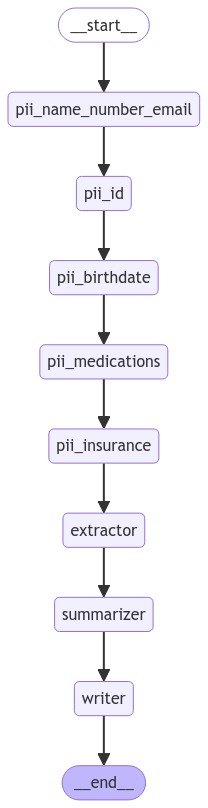

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

In [27]:
# input_text = data.iloc[0]['text']

# output = graph.invoke({"messages": [input_text]})
# output

## Process some examples

In [34]:
all_outputs = []
start = 20
end = 70

for transcript in data.iloc[start:end]['text'].values:
    output = graph.invoke({"messages": [transcript]})
    all_outputs.append(output)